In [5]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
using LinearAlgebra, Plots
import ForwardDiff as FD
using MeshCat
using Test
using Plots

  Activating environment at `~/OCRL/HW1_S24/Project.toml`


# Q2: Equality Constrained Optimization (25 pts)
In this problem, we are going to use Newton's method to solve some constrained optimization problems. We will start with a smaller problem where we can experiment with Full Newton vs Gauss-Newton, then we will use these methods to solve for the motor torques that make a quadruped balance on one leg.

## Part A (10 pts)
Here we are going to solve some equality-constrained optimization problems with Newton's method. We are given a problem 

$$ \begin{align} \min_x \quad & f(x) \\ 
 \mbox{st} \quad & c(x) = 0 
 \end{align}$$
 Which has the following Lagrangian:
 $$ \mathcal{L}(x,\lambda) = f(x) + \lambda ^T c(x), $$
and the following KKT conditions for optimality:
$$\begin{align}
\nabla_x \mathcal{L} = \nabla_x f(x) + \bigg[ \frac{\partial c}{\partial x}\bigg] ^T \lambda &= 0 \\ 
c(x) &= 0 
\end{align}$$

Which is just a root-finding problem. To solve this, we are going to solve for a $z = [x^T,\lambda]^T$ that satisfies these KKT conditions.

### Newton's Method with a Linesearch

We use Newton's method to solve for when $r(z) = 0$. To do this, we specify `res_fx(z)` as $r(z)$, and `res_jac_fx(z)` as $\partial r/ \partial z$. To calculate a Newton step, we do the following:

$$\Delta z = -\bigg[ \frac{\partial r}{\partial z} \bigg]^{-1} r(z_k)$$

We then decide the step length with a linesearch that finds the largest $\alpha \leq 1$ such that the following is true:
$$ \phi(z_k + \alpha \Delta z) < \phi(z_k)$$
Where $\phi$ is a "merit function", or `merit_fx(z)` in the code. In this assignment you will use a backtracking linesearch where $\alpha$ is initialized as $\alpha = 1.0$, and is divided by 2 until the above condition is satisfied.

NOTE: YOU DO NOT NEED TO (AND SHOULD NOT) USE A WHILE LOOP ANYWHERE IN THIS ASSIGNMENT. 

In [8]:
function linesearch(z::Vector, Δz::Vector, merit_fx::Function;
                    max_ls_iters = 10)::Float64 # optional argument with a default
    
    # TODO: return maximum α≤1 such that merit_fx(z + α*Δz) < merit_fx(z)
    # with a backtracking linesearch (α = α/2 after each iteration)

    # NOTE: DO NOT USE A WHILE LOOP 
    α = 1
    for i = 1:max_ls_iters
        # TODO: return α when merit_fx(z + α*Δz) < merit_fx(z)
        phi = merit_fx(z + α*Δz)
        if phi < merit_fx(z)
            return α
        else
            α = α/2
        end
    end
    # error("linesearch failed")
end

function newtons_method(z0::Vector, res_fx::Function, res_jac_fx::Function, merit_fx::Function;
                        tol = 1e-10, max_iters = 50, verbose = false)::Vector{Vector{Float64}}
    
    # TODO: implement Newton's method given the following inputs:
    # - z0, initial guess 
    # - res_fx, residual function 
    # - res_jac_fx, Jacobian of residual function wrt z 
    # - merit_fx, merit function for use in linesearch 
    
    # optional arguments 
    # - tol, tolerance for convergence. Return when norm(residual)<tol 
    # - max iter, max # of iterations 
    # - verbose, bool telling the function to output information at each iteration
    
    # return a vector of vectors containing the iterates 
    # the last vector in this vector of vectors should be the approx. solution 
    
    # NOTE: DO NOT USE A WHILE LOOP ANYWHERE 
    
    # return the history of guesses as a vector
    Z = [zeros(length(z0)) for i = 1:max_iters]
    Z[1] = z0 
    
    for i = 1:(max_iters - 1)
        
        # NOTE: everything here is a suggestion, do whatever you want to 
        
        # TODO: evaluate current residual 
        current_residual = res_fx(Z[i])
        norm_r = norm(current_residual, Inf) # TODO: update this 

        if verbose 
            print("iter: $i    |r|: $norm_r   ")
        end
        
        # TODO: check convergence with norm of residual < tol 
        # if converged, return Z[1:i]
        if norm_r < tol
            return Z[1:i]
        end
        
        # TODO: caculate Newton step (don't forget the negative sign)
        Δz = - inv(res_jac_fx(Z[i])) * current_residual #Backslash is used for the inverse??
        
        # TODO: linesearch and update z 
        α = linesearch(Z[i], Δz,merit_fx)
        Z[i+1] = Z[i] + α*Δz
        if verbose
            print("α: $α \n")
        end
        
    end
    error("Newton's method did not converge")
end

newtons_method (generic function with 1 method)

In [9]:
@testset "check Newton" begin 
    
    f(_x) = [sin(_x[1]), cos(_x[2])]
    df(_x) = FD.jacobian(f, _x)
    merit(_x) = norm(f(_x))
    
    x0 = [-1.742410372590328, 1.4020334125022704]
    
    X = newtons_method(x0, f, df, merit; tol = 1e-10, max_iters = 50, verbose = true)
    
    # check this took the correct number of iterations
    # if your linesearch isn't working, this will fail 
    # you should see 1 iteration where α = 0.5 
    @test length(X) == 6 
    
    # check we actually converged
    @test norm(f(X[end])) < 1e-10
    
end

iter: 1    |r|: 0.9853104151741932   α: 1.0 


iter: 2    |r|: 0.9421328488163083   α: 0.5 
iter: 3    |r|: 0.17531541822305458   α: 1.0 
iter: 4    |r|: 0.0018472215879181202   α: 1.0 
iter: 5    |r|: 2.1010529101114835e-9   α: 1.0 
iter: 6    |r|: 2.4492935982947064e-16   Test Summary: | Pass  Total
check Newton  |    2      2


Test.DefaultTestSet("check Newton", Any[], 2, false, false)

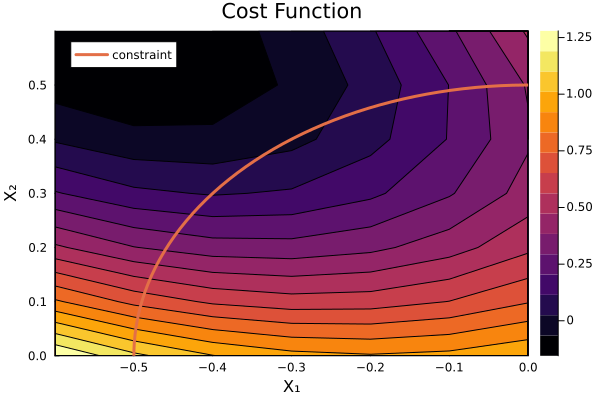

In [10]:
let
    function plotting_cost(x::Vector)
        Q = [1.65539  2.89376; 2.89376  6.51521];
        q = [2;-3]
        return 0.5*x'*Q*x + q'*x + exp(-1.3*x[1] + 0.3*x[2]^2)
    end
    contour(-.6:.1:0,0:.1:.6, (x1,x2)-> plotting_cost([x1;x2]),title = "Cost Function",
            xlabel = "X₁", ylabel = "X₂",fill = true)
    xcirc = [.5*cos(θ) for θ in range(0, 2*pi, length = 200)]
    ycirc = [.5*sin(θ) for θ in range(0, 2*pi, length = 200)]
    plot!(xcirc,ycirc, lw = 3.0, xlim = (-.6, 0), ylim = (0, .6),label = "constraint")
end

We will now use Newton's method to solve the following constrained optimization problem. We will write functions for the full Newton Jacobian, as well as the Gauss-Newton Jacobian. 

In [49]:
# we will use Newton's method to solve the constrained optimization problem shown above
function cost(x::Vector)
    Q = [1.65539  2.89376; 2.89376  6.51521];
    q = [2;-3]
    return 0.5*x'*Q*x + q'*x + exp(-1.3*x[1] + 0.3*x[2]^2)
end
function constraint(x::Vector)
    norm(x) - 0.5 
end
# HINT: use this if you want to, but you don't have to
function constraint_jacobian(x::Vector)::Matrix
    # since `constraint` returns a scalar value, ForwardDiff 
    # will only allow us to compute a gradient of this function 
    # (instead of a Jacobian). This means we have two options for
    # computing the Jacobian: Option 1 is to just reshape the gradient
    # into a row vector
    
    # J = reshape(FD.gradient(constraint, x), 1, 2)
    
    # or we can just make the output of constraint an array, 
    constraint_array(_x) = [constraint(_x)]
    J = FD.jacobian(constraint_array, x)
    
    # assert the jacobian has # rows = # outputs 
    # and # columns = # inputs 
    @assert size(J) == (length(constraint(x)), length(x))
    
    return J 
end
function kkt_conditions(z::Vector)::Vector
    # TODO: return the KKT conditions

    x = z[1:2]
    λ = z[3:3]
    kkt_conditions = zeros(length(z))

    # TODO: return the stationarity condition for the cost function
    c = cost(x) # cost function
    ∇c = FD.gradient(cost,x)
    J = constraint_jacobian(x)
    kkt_conditions[1:2] = ∇c .+ J'*λ
    kkt_conditions[3] = constraint(x)
    # and the primal feasibility

    return kkt_conditions
end

function fn_kkt_jac(z::Vector)::Matrix
    # TODO: return full Newton Jacobian of kkt conditions wrt z
    x = z[1:2]
    λ = z[3]
    J_fn_kkt = zeros(2,2)
    reg = 1e-3
    # c = cost(dx)
    L(dx) = cost(dx) .+ λ'*constraint(dx)  #Lagrangian term
    J = constraint_jacobian(x)
    # TODO: return full Newton jacobian with a 1e-3 regularizer
    J_fn_kkt = [(FD.hessian(dx -> L(dx), x) + reg*I) J'; J -reg*I]
    return J_fn_kkt 
end


function gn_kkt_jac(z::Vector)::Matrix
    # TODO: return Gauss-Newton Jacobian of kkt conditions wrt z 
    x = z[1:2]
    λ = z[3]

    # TODO: return Gauss-Newton jacobian with a 1e-3 regularizer
    J_gn_kkt = zeros(2,2)
    reg = 1e-3
    # c = cost(dx)
    L(dx) = cost(dx) .+ λ'*constraint(dx)  #Lagrangian term
    J = constraint_jacobian(x)
    J_gn_kkt = [(FD.hessian(dx -> cost(dx), x) + reg*I) J'; J -reg*I]
    return J_gn_kkt 
end

gn_kkt_jac (generic function with 1 method)

In [94]:
@testset "Test Jacobians" begin 
    
    # first we check the regularizer 
    z = randn(3)
    J_fn = fn_kkt_jac(z)
    J_gn = gn_kkt_jac(z)
    
    # check what should/shouldn't be the same between 
    @test norm(J_fn[1:2,1:2] - J_gn[1:2,1:2]) > 1e-10
    @test abs(J_fn[3,3] + 1e-3) < 1e-10
    @test abs(J_gn[3,3] + 1e-3) < 1e-10
    @test norm(J_fn[1:2,3] - J_gn[1:2,3]) < 1e-10
    @test norm(J_fn[3,1:2] - J_gn[3,1:2]) < 1e-10
end

J_gn = [5.9906801663114475 3.560765760890812 -0.9025324581596084; 3.560765760890812 8.157657043286878 -0.4306218317368209; -0.9025324581596084 -0.4306218317368209 -0.001]
Test Summary:  | Pass  Total
Test Jacobians |    5      5


Test.DefaultTestSet("Test Jacobians", Any[], 5, false, false)

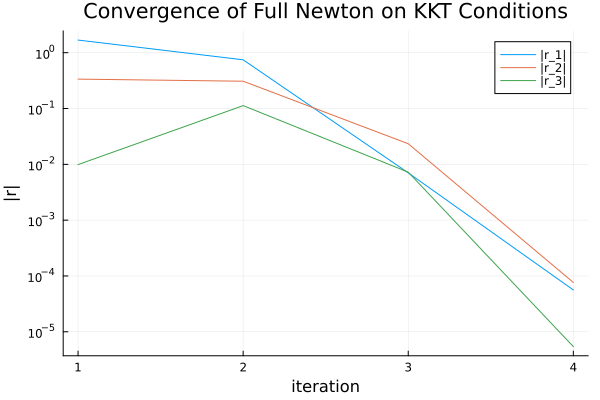

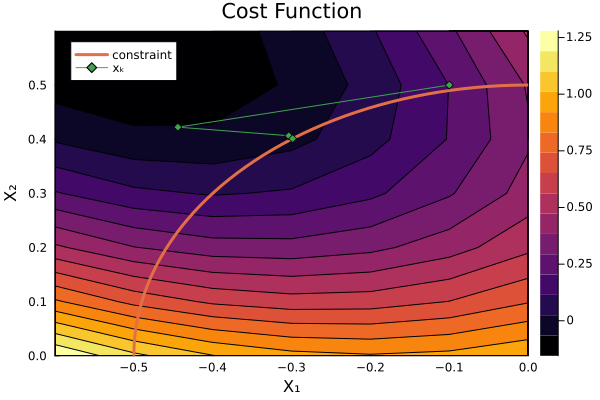

iter: 1    |r|: 1.6855584155478687   α: 1.0 
iter: 2    |r|: 0.7459047551922087   α: 1.0 
iter: 3    |r|: 0.023362325158016173   α: 1.0 
iter: 4    |r|: 7.649879975402119e-5   Test Summary: | 

Pass  Total
Full Newton   |    2      2


Test.DefaultTestSet("Full Newton", Any[], 2, false, false)

In [28]:
@testset "Full Newton" begin 
    
    
    z0 = [-.1, .5, 0] # initial guess
    merit_fx(_z) = norm(kkt_conditions(_z)) # simple merit function
    Z = newtons_method(z0, kkt_conditions, fn_kkt_jac, merit_fx; tol = 1e-4, max_iters = 100, verbose = true)
    R = kkt_conditions.(Z)

    # make sure we converged on a solution to the KKT conditions 
    @test norm(kkt_conditions(Z[end])) < 1e-4
    @test length(R) < 6
    
    
    # ------------------------plotting stuff------------------------
    Rp = [[abs(R[i][ii]) + 1e-15 for i = 1:length(R)] for ii = 1:length(R[1])] # this gets abs of each term at each iteration
    
    plot(Rp[1],yaxis=:log,ylabel = "|r|",xlabel = "iteration",
         yticks= [1.0*10.0^(-x) for x = float(15:-1:-2)],
         title = "Convergence of Full Newton on KKT Conditions",label = "|r_1|")
    plot!(Rp[2],label = "|r_2|")
    display(plot!(Rp[3],label = "|r_3|"))
    
    contour(-.6:.1:0,0:.1:.6, (x1,x2)-> cost([x1;x2]),title = "Cost Function",
            xlabel = "X₁", ylabel = "X₂",fill = true)
    xcirc = [.5*cos(θ) for θ in range(0, 2*pi, length = 200)]
    ycirc = [.5*sin(θ) for θ in range(0, 2*pi, length = 200)]
    plot!(xcirc,ycirc, lw = 3.0, xlim = (-.6, 0), ylim = (0, .6),label = "constraint")
    z1_hist = [z[1] for z in Z]
    z2_hist = [z[2] for z in Z]
    display(plot!(z1_hist, z2_hist, marker = :d, label = "xₖ"))
    # ------------------------plotting stuff------------------------
end

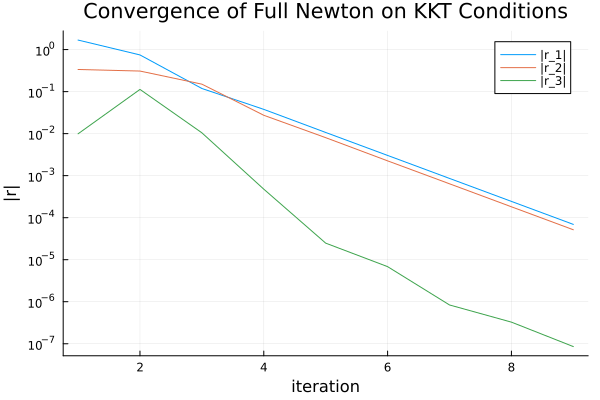

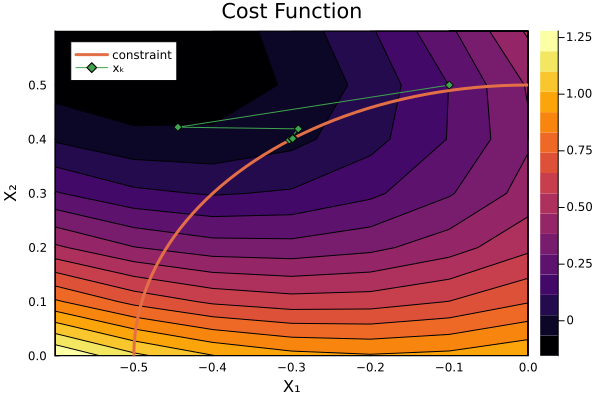

iter: 1    |r|: 1.6855584155478687   α: 1.0 
iter: 2    |r|: 0.7459047551922087   α: 1.0 
iter: 3    |r|: 0.1504394734838188   α: 1.0 
iter: 4    |r|: 0.03778566208310541   α: 1.0 
iter: 5    |r|: 0.010653168981697325   α: 1.0 
iter: 6    |r|: 0.003027606542100325   α: 1.0 
iter: 7    |r|: 0.0008588845232736508   α: 1.0 
iter: 8    |r|: 0.00024377563414024195   α: 1.0 
iter: 9    |r|: 6.918044121528855e-5   Test Summary: | 

Pass  Total
Gauss-Newton  |    2      2


Test.DefaultTestSet("Gauss-Newton", Any[], 2, false, false)

In [29]:
@testset "Gauss-Newton" begin 
    
    
    z0 = [-.1, .5, 0] # initial guess
    merit_fx(_z) = norm(kkt_conditions(_z)) # simple merit function
    
    # the only difference in this block vs the previous is `gn_kkt_jac` instead of `fn_kkt_jac`
    Z = newtons_method(z0, kkt_conditions, gn_kkt_jac, merit_fx; tol = 1e-4, max_iters = 100, verbose = true)
    R = kkt_conditions.(Z)

    # make sure we converged on a solution to the KKT conditions 
    @test norm(kkt_conditions(Z[end])) < 1e-4
    @test length(R) < 10
    
    
    # ------------------------plotting stuff------------------------
    Rp = [[abs(R[i][ii]) + 1e-15 for i = 1:length(R)] for ii = 1:length(R[1])] # this gets abs of each term at each iteration
    
    plot(Rp[1],yaxis=:log,ylabel = "|r|",xlabel = "iteration",
         yticks= [1.0*10.0^(-x) for x = float(15:-1:-2)],
         title = "Convergence of Full Newton on KKT Conditions",label = "|r_1|")
    plot!(Rp[2],label = "|r_2|")
    display(plot!(Rp[3],label = "|r_3|"))
    
    contour(-.6:.1:0,0:.1:.6, (x1,x2)-> cost([x1;x2]),title = "Cost Function",
            xlabel = "X₁", ylabel = "X₂",fill = true)
    xcirc = [.5*cos(θ) for θ in range(0, 2*pi, length = 200)]
    ycirc = [.5*sin(θ) for θ in range(0, 2*pi, length = 200)]
    plot!(xcirc,ycirc, lw = 3.0, xlim = (-.6, 0), ylim = (0, .6),label = "constraint")
    z1_hist = [z[1] for z in Z]
    z2_hist = [z[2] for z in Z]
    display(plot!(z1_hist, z2_hist, marker = :d, label = "xₖ"))
    # ------------------------plotting stuff------------------------
end

## Part B (10 pts): Balance a quadruped
Now we are going to solve for the control input $u \in \mathbb{R}^{12}$, and state $x \in \mathbb{R}^{30}$, such that the quadruped is balancing up on one leg at an equilibrium point. First, let's load in a dynamics model from `quadruped.jl`, where 

$ \dot{x} = f(x,u) =$ `dynamics(model, x, u)`



In [51]:
# include the functions from quadruped.jl
include(joinpath(@__DIR__, "quadruped.jl"))

# this loads in our continuous time dynamics function xdot = dynamics(model, x, u)

initialize_visualizer (generic function with 1 method)

let's load in a model and display the rough "guess" configuration that we are going for:

In [52]:
# --------these three are global variables------------
model = UnitreeA1() # contains all the model properties for the quadruped
mvis = initialize_visualizer(model) # visualizer 
const x_guess = initial_state(model) # our guess state for balancing
# ----------------------------------------------------

set_configuration!(mvis, x_guess[1:state_dim(model)/2])
render(mvis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat /home/rsharde/.julia/packages/MeshCat/vWPbP/src/visualizer.jl:73


ArgumentError: ArgumentError: invalid index: 1.0 of type Float64

Now, we are going to solve for the state and control that get us an equilibrium (balancing) on just one leg. We are going to do this by solving the following optimization problem:

$$ \begin{align} \min_{x,u} \quad & \frac{1}{2}(x - x_{guess})^T(x - x_{guess}) + \frac{1}{2}10^{-3} u^Tu \\ 
 \mbox{st} \quad & \dot{x} = f(x,u) = 0 
 \end{align}$$
 
 Where our primal variables are $x \in \mathbb{R}^{30}$ and $u \in \mathbb{R}^{12}$, that we can stack up in a new variable $y = [x^T, u^T]^T \in \mathbb{R}^{42}$. We have a constraint $\dot{x} = f(x,u) = 0$, which will ensure the resulting configuration is an equilibrium. This constraint is enforced with a dual variable $\lambda \in \mathbb{R}^{30}$. We are now ready to use Newton's method to solve this equality constrained optimization problem, where we will solve for a variable $z = [y^T, \lambda^T]^T \in \mathbb{R}^{72}$.
 
 In this next section, you should fill out `quadruped_kkt(z)` with the KKT conditions for this optimization problem, given the constraint is that `dynamics(model, x, u) = zeros(30)`. When forming the Jacobian of the KKT conditions, use the Gauss-Newton approximation for the hessian of the Lagrangian (see example above if you're having trouble with this).

In [113]:
# initial guess 
const x_guess = initial_state(model)

# indexing stuff 
const idx_x = 1:30 
const idx_u = 31:42
const idx_c = 43:72

# I like stacking up all the primal variables in y, where y = [x;u]
# Newton's method will solve for z = [x;u;λ], or z = [y;λ]

function quadruped_cost(y::Vector)
    # cost function 
    @assert length(y) == 42
    x = y[idx_x]
    u = y[idx_u]
    
    # TODO: return cost 
    cost = 0.5*(x-x_guess)'*(x-x_guess)+0.5*((10^(-3))*u'*u)
    return cost
end
function quadruped_constraint(y::Vector)::Vector
    # constraint function 
    @assert length(y) == 42
    x = y[idx_x]
    u = y[idx_u]
    
    # TODO: return constraint
    # error("quadruped constraint not implemented")
    # x_dot = FD.derivative(y,x)
    constraint = dynamics(model,x,u) 
    return constraint
end
function quadruped_kkt(z::Vector)::Vector
    @assert length(z) == 72 
    x = z[idx_x]
    u = z[idx_u]
    λ = z[idx_c]
    
    y = [x;u]
    # TODO: return the KKT conditions 
    J = FD.jacobian(quadruped_constraint,y)
    kkt_cond = [FD.gradient(quadruped_cost,y) + J'*λ; quadruped_constraint(y)]
    return kkt_cond
end

function quadruped_kkt_jac(z::Vector)::Matrix
    @assert length(z) == 72 
    x = z[idx_x]
    u = z[idx_u]
    λ = z[idx_c]
    
    y = [x;u]
    # L(dx) = cost(dx) .+ λ'*constraint(dx)  #Lagrangian term
    # J = constraint_jacobian(x)
    # J_gn_kkt = [(FD.hessian(dx -> cost(dx), x) + reg*I) J'; J -reg*I]

    # TODO: return Gauss-Newton Jacobian with a regularizer (try 1e-3,1e-4,1e-5,1e-6)
    # and use whatever regularizer works for you
    # L(dy) = quadruped_cost(dy) .+ λ'*quadruped_constraint(dy)  #Lagrangian term
    
    B = 1e-3
    J = FD.jacobian(quadruped_constraint,y)
    J_gn = [FD.hessian(quadruped_cost,y)+B*I J';J -B*I]
    # error("quadruped kkt jac not implemented")
    return J_gn
end

quadruped_kkt_jac (generic function with 1 method)

iter: 1    |r|: 172.1669185189028   α: 1.0 


iter: 2    |r|: 102.34579254406071   α: 1.0 
iter: 3    |r|: 34.3823956642315   α: 0.5 
iter: 4    |r|: 16.106345867644208   α: 0.25 


iter: 5    |r|: 12.891067357897528   α: 0.5 
iter: 6    |r|: 13.611440847341227   α: 1.0 
iter: 7    |r|: 7.6862149372807185   α: 1.0 
iter: 8    |r|: 0.6262116041765683   α: 1.0 
iter: 9    |r|: 0.805274572125095   α: 1.0 
iter: 10    |r|: 1.537125876961492   α: 1.0 
iter: 11    |r|: 0.010568630313613658   α: 1.0 


iter: 12    |r|: 0.000327361161290618   α: 1.0 
iter: 13    |r|: 0.000609291073245144   α: 1.0 
iter: 14    |r|: 7.937680447911433e-5   α: 1.0 


iter: 15    |r|: 1.7074286326468346e-5   α: 1.0 
iter: 16    |r|: 4.034879679204462e-6   α: 1.0 
iter: 17    |r|: 1.0134926500260377e-6   α: 1.0 
iter: 18    |r|: 2.6115291112960293e-7   

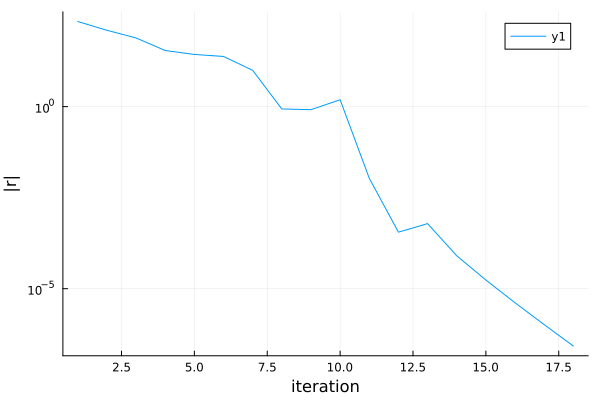

Test Summary:      | Pass  Total
quadruped standing |    3      3


Test.DefaultTestSet("quadruped standing", Any[], 3, false, false)

In [114]:
function quadruped_merit(z)
    # merit function for the quadruped problem 
    
    @assert length(z) == 72 
    r = quadruped_kkt(z)
    return norm(r[1:42]) + 1e4*norm(r[43:end])
end

@testset "quadruped standing" begin
    
    z0 = [x_guess; zeros(12); zeros(30)]
    Z = newtons_method(z0, quadruped_kkt, quadruped_kkt_jac, quadruped_merit; tol = 1e-6, verbose = true, max_iters = 50)
    
    set_configuration!(mvis, Z[end][1:state_dim(model)÷2])
    R = norm.(quadruped_kkt.(Z))
    
    display(plot(1:length(R), R, yaxis=:log,xlabel = "iteration", ylabel = "|r|"))
    
    
    @test R[end] < 1e-6
    @test length(Z) < 25
    
    x,u = Z[end][idx_x], Z[end][idx_u]
    
    @test norm(dynamics(model, x, u)) < 1e-6
    
end

In [108]:
let
    
    # let's visualize the balancing position we found
    
    z0 = [x_guess; zeros(12); zeros(30)]
    Z = newtons_method(z0, quadruped_kkt, quadruped_kkt_jac, quadruped_merit; tol = 1e-6, verbose = false, max_iters = 50)
    # visualizer 
    mvis = initialize_visualizer(model)
    set_configuration!(mvis, Z[end][1:state_dim(model)÷2])
    render(mvis)
    
    
end

ArgumentError: ArgumentError: number of columns of each array must match (got (1, 42))

## Part C (5 pts): One sentence short answer

1. Why do we use a linesearch? 

**Linesearch is used to adjust the step size along a search direction and can help to converge faster.**

2. Do we need a linesearch for both convex and nonconvex problems?

**It can be used in both problems to get an efficient step size along the search direction and help converge faster.**

3. Name one case where we absolutely do not need a linesearch.

**A linesearch would not be needed in the case where the function is quadritic with a positive definite Hessian matrix, the optimal step size can be determined as the gradient descent direction is always the steepest direction.**